In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, NaiveBayes,\
                                        RandomForestClassifier
from pyspark.ml.feature import  OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.sql import functions as F, SparkSession
import seaborn as sb
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import winsound as sound

# Create SparkSession, read CSV file.

In [2]:
# Create SparkSession.
spark = SparkSession.builder.appName('Bank Data - Logistic Regression').getOrCreate()

In [3]:
# Read CSV into pandas dataframe.
df = pd.read_csv('./bankdata.csv')

# Preprocessing.

## Scale numerical columns.

In [4]:
# List of every numerical column.
age_list = df['age'].values.astype('float').tolist()
balance_list = df['balance'].values.astype('float').tolist()
campaign_list = df['campaign'].values.astype('float').tolist()
day_list = df['day'].values.astype('float').tolist()
pdays_list = df['pdays'].values.astype('float').tolist()
previous_list = df['previous'].values.astype('float').tolist()

# Apply sklearn's MixMaxScaler to each list.
scaler = MinMaxScaler()

# Create scaled data lists.
scaled_age = scaler.fit_transform(np.reshape(age_list, (-1,1)))
scaled_balance = scaler.fit_transform(np.reshape(balance_list, (-1,1)))
scaled_campaign = scaler.fit_transform(np.reshape(campaign_list, (-1,1)))
scaled_day = scaler.fit_transform(np.reshape(day_list, (-1,1)))
scaled_pdays = scaler.fit_transform(np.reshape(pdays_list, (-1,1)))
scaled_previous = scaler.fit_transform(np.reshape(previous_list, (-1,1)))

# Add scaled columns to dataframe.
df['scaled_age'] = scaled_age
df['scaled_balance'] = scaled_balance
df['scaled_campaign'] = scaled_campaign
df['scaled_day'] = scaled_day
df['scaled_pdays'] = scaled_pdays
df['scaled_previous'] = scaled_previous

# Drop unscaled columns.
df.drop(['age','balance','campaign','day','pdays','previous'], axis=1, inplace=True)

## Create new join indicator column 'subscribed'.

In [5]:
df['subscribed'] = [1 if x == 'yes' else 0 for x in df['y']]

In [6]:
# Drop original indicator column.
df.drop(['y'], axis=1, inplace=True)

## Cut down non-join data rows until equality between join and non-join.

In [7]:
# Find all join rows.
joined_df = df.loc[df['subscribed'] == 1]

# Calculate number of joins.
num_positive = joined_df.shape[0]

# Take random sample of non-join rows.
non_joined_sample_df = df.loc[df['subscribed'] == 0].sample(n=num_positive)

# Create dataframe of chosen rows.
equal_split_df = joined_df.append(non_joined_sample_df)

# Conver to Spark dataframe.
equal_split_spark_df = spark.createDataFrame(equal_split_df,schema=equal_split_df.columns.tolist())

## Use StringIndexer on categorical variable columns.

In [8]:
# Features that are categorical.
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# List of indexers to apply to the data.
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(equal_split_spark_df) for column in categorical_features]

# Create and apply the indexers.
pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(equal_split_spark_df).transform(equal_split_spark_df)

# Drop original columns.
indexed_df = indexed_df.drop('job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome')

## Create sparse vectors of each indexed column.

In [9]:
# List of columns that are indexed.
indexed_cols = ['job_index','marital_index', 'education_index','default_index', 'housing_index', 'loan_index', 'contact_index',
                'month_index', 'poutcome_index']

# Create encoder.
encoder = OneHotEncoderEstimator(inputCols=indexed_cols,
                                 outputCols=[feat + '_sparse' for feat in indexed_cols])

# Fit and apply encoder to dataframe.
model = encoder.fit(indexed_df)
sparse_indexed_df = model.transform(indexed_df)

# Drop non-sparse indexed columns.
sparse_indexed_df = sparse_indexed_df.drop('job_index','marital_index', 'education_index','default_index', 'housing_index',
                                           'loan_index', 'contact_index','month_index', 'poutcome_index')

## Use VectorAssembler to compress all independent variable columns into a dense vector.

In [10]:
IV_features = ['housing_index_sparse', 'contact_index_sparse', 'job_index_sparse', 'loan_index_sparse', 'marital_index_sparse',
               'default_index_sparse', 'poutcome_index_sparse', 'scaled_balance', 'scaled_campaign', 'scaled_previous',
               'scaled_campaign', 'scaled_day', 'scaled_pdays', 'scaled_age']

# Create the vector assembler and name the vector column "features".
vec_assembler = VectorAssembler(inputCols=IV_features, outputCol='features')

# Create the new dataframe that has the "features" column of dense vectors..
dense_df = vec_assembler.transform(sparse_indexed_df)

## Split data into training, testing, and validation datasets.

In [11]:
# Create a dataframe consisting only of IV vector and the subscribed indicator.
processed_df = dense_df.select('features', 'subscribed')

In [12]:
# Split the data into three categories: training data, testing data, and validation data.
train, test, valid = processed_df.randomSplit([.6, .2, .2])

# Logistic Regression model.

In [13]:
# Create Logistic Regression model, fit the model to the training data.
model = LogisticRegression(labelCol='subscribed')
model = model.fit(train)

In [14]:
# Get predictions for the testing data.
test_preds = model.transform(test)

# Get predictions for the validation data.
valid_preds = model.transform(valid)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [15]:
# Lists of actual labels and predicted labels.
test_actual = test_preds.select('subscribed').collect()
test_pred = test_preds.select('prediction').collect()

# Useful statistics
test_accuracy = metrics.accuracy_score(test_actual, test_pred)
test_precision = metrics.precision_score(test_actual, test_pred)
test_recall = metrics.recall_score(test_actual, test_pred)
test_f1_score = metrics.f1_score(test_actual, test_pred)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [16]:
# Lists of actual labels and predicted labels.
valid_actual = valid_preds.select('subscribed').collect()
valid_pred = valid_preds.select('prediction').collect()

# Useful statistics
valid_accuracy = metrics.accuracy_score(valid_actual, valid_pred)
valid_precision = metrics.precision_score(valid_actual, valid_pred)
valid_recall = metrics.recall_score(valid_actual, valid_pred)
valid_f1_score = metrics.f1_score(valid_actual, valid_pred)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [17]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [18]:
test_cm = metrics.confusion_matrix(test_actual, test_pred)
valid_cm = metrics.confusion_matrix(valid_actual, valid_pred)

### Receiver Operating Characteristics.

In [19]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(test_actual, test_pred)
test_auc = metrics.auc(test_fpr, test_tpr)

In [20]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(valid_actual, valid_pred)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [21]:
# Get subscribed probability on test predictions.
test_probs_rows = test_preds.select('probability').collect()
test_probs = [test_probs_rows[i][0][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(test_actual, test_probs)

In [22]:
# Get subscribed probability on validation predictions.
valid_probs_rows = valid_preds.select('probability').collect()
valid_probs = [valid_probs_rows[i][0][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(valid_actual, valid_probs)

## Plot graphs and statistics.

In [23]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [24]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

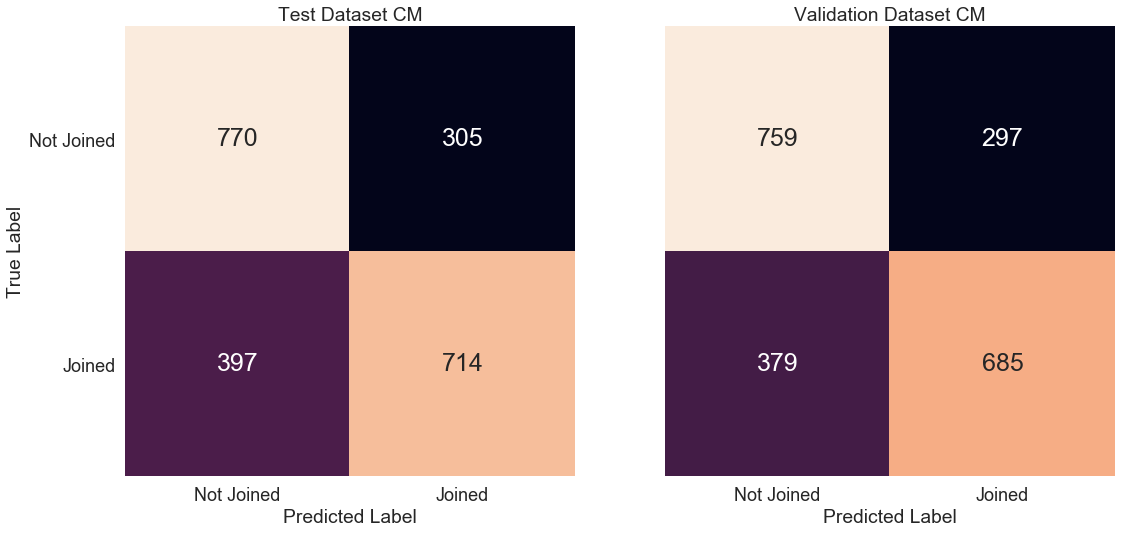

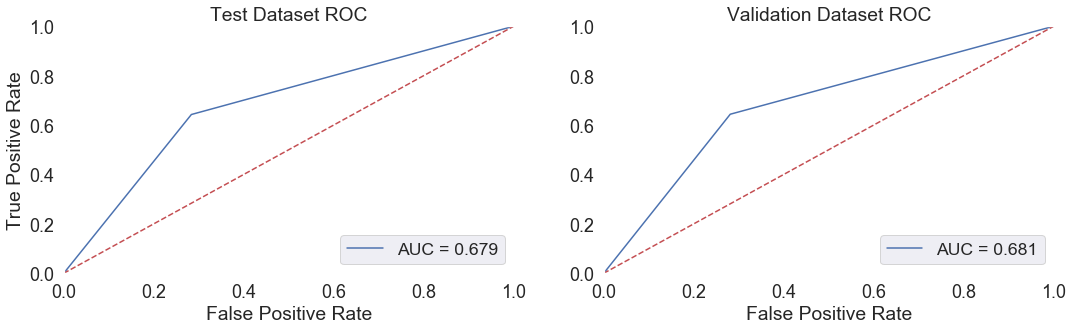

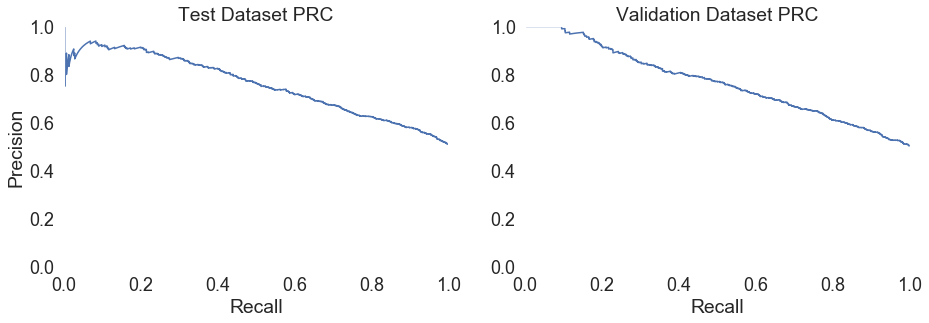

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.678866,0.681132
1,Precision,0.700687,0.697556
2,Recall,0.642664,0.643797
3,F1 Score,0.670423,0.669599


In [25]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# Decision Tree model.

In [26]:
# Create Decision Tree model, fit the model to the training data.
model = DecisionTreeClassifier(labelCol='subscribed')
model = model.fit(train)

In [27]:
# Get predictions for the testing data.
test_preds = model.transform(test)

# Get predictions for the validation data.
valid_preds = model.transform(valid)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [28]:
# Lists of actual labels and predicted labels.
test_actual = test_preds.select('subscribed').collect()
test_pred = test_preds.select('prediction').collect()

# Useful statistics
test_accuracy = metrics.accuracy_score(test_actual, test_pred)
test_precision = metrics.precision_score(test_actual, test_pred)
test_recall = metrics.recall_score(test_actual, test_pred)
test_f1_score = metrics.f1_score(test_actual, test_pred)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [29]:
# Lists of actual labels and predicted labels.
valid_actual = valid_preds.select('subscribed').collect()
valid_pred = valid_preds.select('prediction').collect()

# Useful statistics
valid_accuracy = metrics.accuracy_score(valid_actual, valid_pred)
valid_precision = metrics.precision_score(valid_actual, valid_pred)
valid_recall = metrics.recall_score(valid_actual, valid_pred)
valid_f1_score = metrics.f1_score(valid_actual, valid_pred)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [30]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [31]:
test_cm = metrics.confusion_matrix(test_actual, test_pred)
valid_cm = metrics.confusion_matrix(valid_actual, valid_pred)

### Receiver Operating Characteristics.

In [32]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(test_actual, test_pred)
test_auc = metrics.auc(test_fpr, test_tpr)

In [33]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(valid_actual, valid_pred)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [34]:
# Get subscribed probability on test predictions.
test_probs_rows = test_preds.select('probability').collect()
test_probs = [test_probs_rows[i][0][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(test_actual, test_probs)

In [35]:
# Get subscribed probability on validation predictions.
valid_probs_rows = valid_preds.select('probability').collect()
valid_probs = [valid_probs_rows[i][0][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(valid_actual, valid_probs)

## Plot graphs and statistics.

In [36]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [37]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

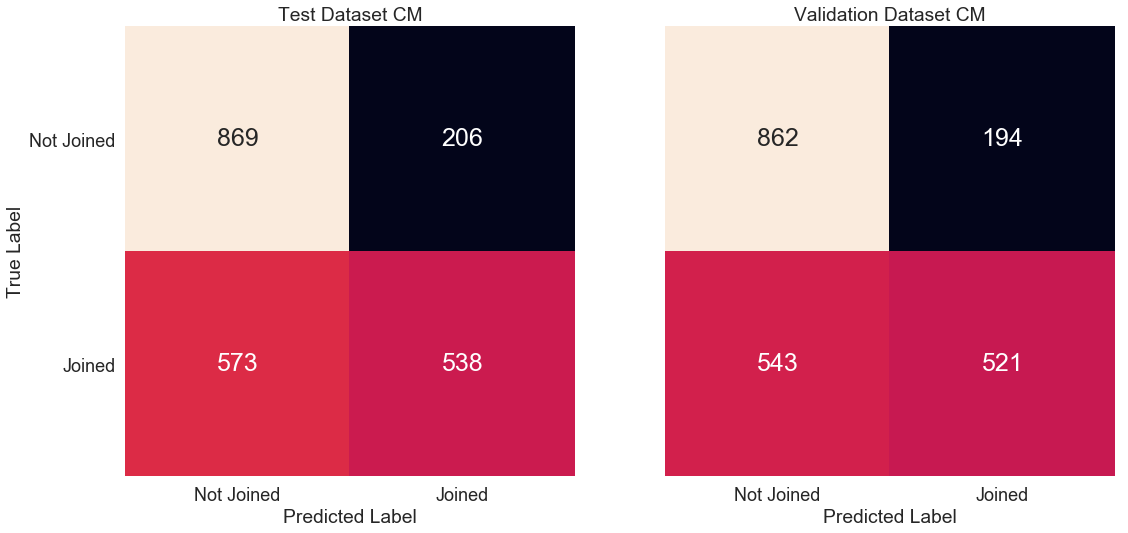

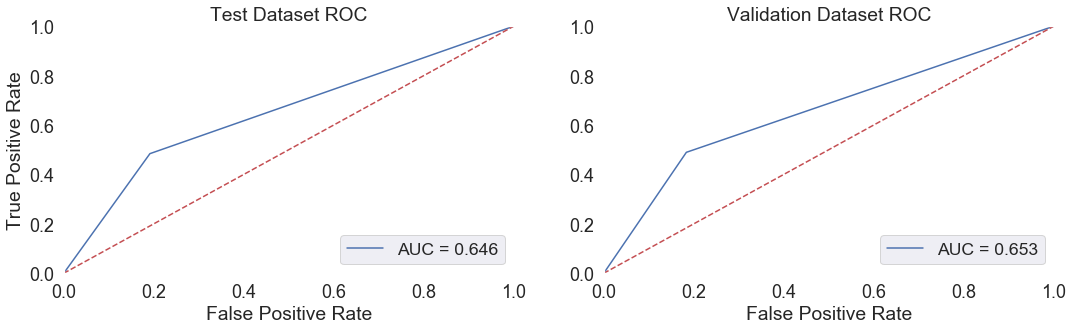

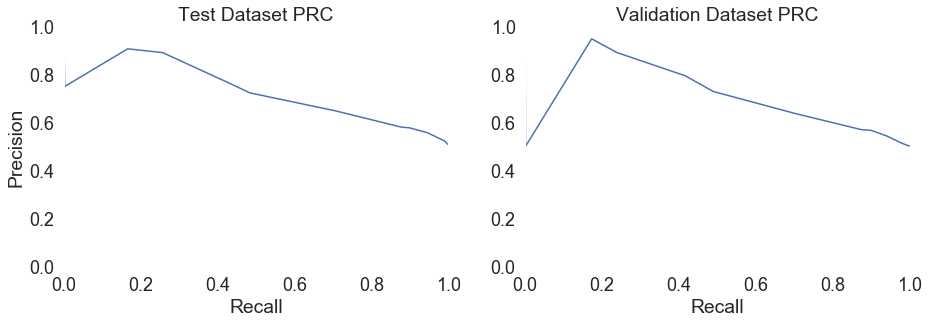

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.643641,0.652358
1,Precision,0.723118,0.728671
2,Recall,0.484248,0.489662
3,F1 Score,0.580054,0.585722


In [38]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# Gradient-boosted Tree model.

In [39]:
# Create Gradient-boosted Tree model, fit the model to the training data.
model = GBTClassifier(labelCol='subscribed')
model = model.fit(train)

In [40]:
# Get predictions for the testing data.
test_preds = model.transform(test)

# Get predictions for the validation data.
valid_preds = model.transform(valid)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [41]:
# Lists of actual labels and predicted labels.
test_actual = test_preds.select('subscribed').collect()
test_pred = test_preds.select('prediction').collect()

# Useful statistics
test_accuracy = metrics.accuracy_score(test_actual, test_pred)
test_precision = metrics.precision_score(test_actual, test_pred)
test_recall = metrics.recall_score(test_actual, test_pred)
test_f1_score = metrics.f1_score(test_actual, test_pred)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [42]:
# Lists of actual labels and predicted labels.
valid_actual = valid_preds.select('subscribed').collect()
valid_pred = valid_preds.select('prediction').collect()

# Useful statistics
valid_accuracy = metrics.accuracy_score(valid_actual, valid_pred)
valid_precision = metrics.precision_score(valid_actual, valid_pred)
valid_recall = metrics.recall_score(valid_actual, valid_pred)
valid_f1_score = metrics.f1_score(valid_actual, valid_pred)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [43]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [44]:
test_cm = metrics.confusion_matrix(test_actual, test_pred)
valid_cm = metrics.confusion_matrix(valid_actual, valid_pred)

### Receiver Operating Characteristics.

In [45]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(test_actual, test_pred)
test_auc = metrics.auc(test_fpr, test_tpr)

In [46]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(valid_actual, valid_pred)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [47]:
# Get subscribed probability on test predictions.
test_probs_rows = test_preds.select('probability').collect()
test_probs = [test_probs_rows[i][0][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(test_actual, test_probs)

In [48]:
# Get subscribed probability on validation predictions.
valid_probs_rows = valid_preds.select('probability').collect()
valid_probs = [valid_probs_rows[i][0][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(valid_actual, valid_probs)

## Plot graphs and statistics.

In [49]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [50]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

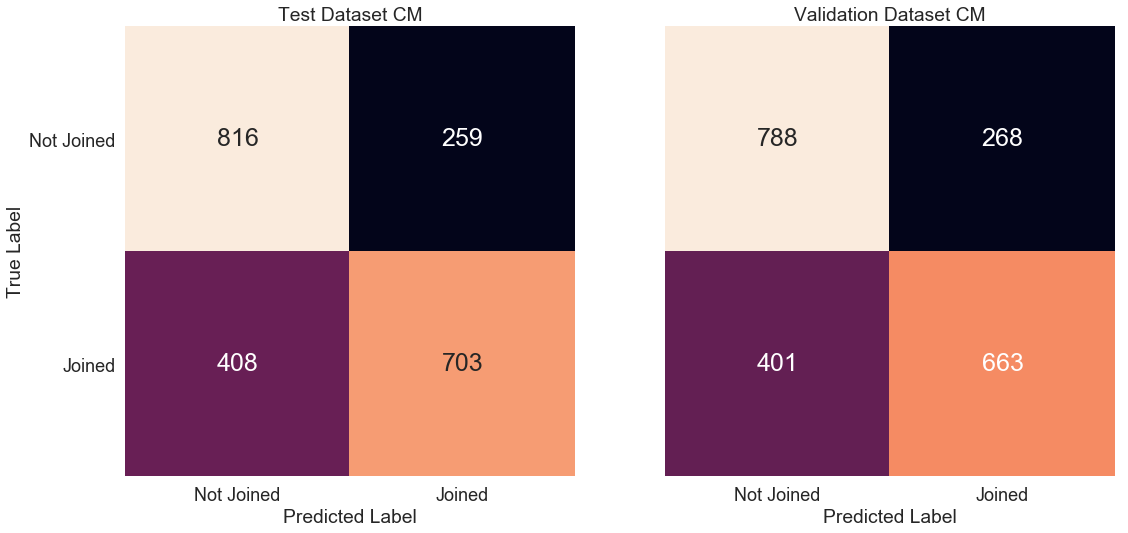

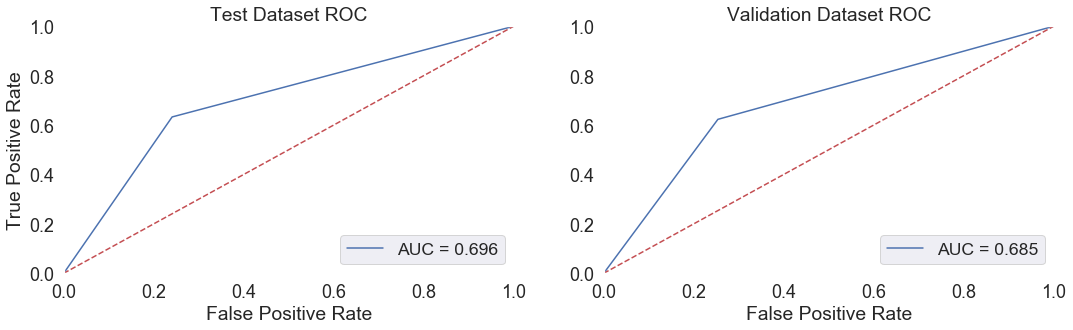

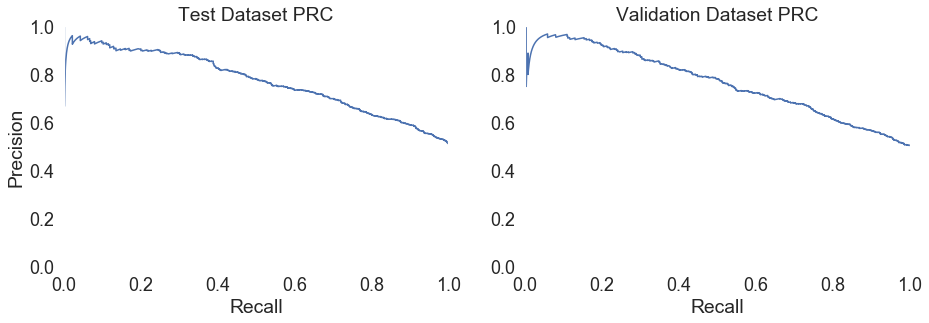

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.694876,0.684434
1,Precision,0.730769,0.712137
2,Recall,0.632763,0.62312
3,F1 Score,0.678244,0.664662


In [51]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# Naive Bayes model.

In [52]:
# Create Naive Bayes model, fit the model to the training data.
model = NaiveBayes(labelCol='subscribed')
model = model.fit(train)

In [53]:
# Get predictions for the testing data.
test_preds = model.transform(test)

# Get predictions for the validation data.
valid_preds = model.transform(valid)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [54]:
# Lists of actual labels and predicted labels.
test_actual = test_preds.select('subscribed').collect()
test_pred = test_preds.select('prediction').collect()

# Useful statistics
test_accuracy = metrics.accuracy_score(test_actual, test_pred)
test_precision = metrics.precision_score(test_actual, test_pred)
test_recall = metrics.recall_score(test_actual, test_pred)
test_f1_score = metrics.f1_score(test_actual, test_pred)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [55]:
# Lists of actual labels and predicted labels.
valid_actual = valid_preds.select('subscribed').collect()
valid_pred = valid_preds.select('prediction').collect()

# Useful statistics
valid_accuracy = metrics.accuracy_score(valid_actual, valid_pred)
valid_precision = metrics.precision_score(valid_actual, valid_pred)
valid_recall = metrics.recall_score(valid_actual, valid_pred)
valid_f1_score = metrics.f1_score(valid_actual, valid_pred)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [56]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [57]:
test_cm = metrics.confusion_matrix(test_actual, test_pred)
valid_cm = metrics.confusion_matrix(valid_actual, valid_pred)

### Receiver Operating Characteristics.

In [58]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(test_actual, test_pred)
test_auc = metrics.auc(test_fpr, test_tpr)

In [59]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(valid_actual, valid_pred)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [60]:
# Get subscribed probability on test predictions.
test_probs_rows = test_preds.select('probability').collect()
test_probs = [test_probs_rows[i][0][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(test_actual, test_probs)

In [61]:
# Get subscribed probability on validation predictions.
valid_probs_rows = valid_preds.select('probability').collect()
valid_probs = [valid_probs_rows[i][0][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(valid_actual, valid_probs)

## Plot graphs and statistics.

In [62]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [63]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

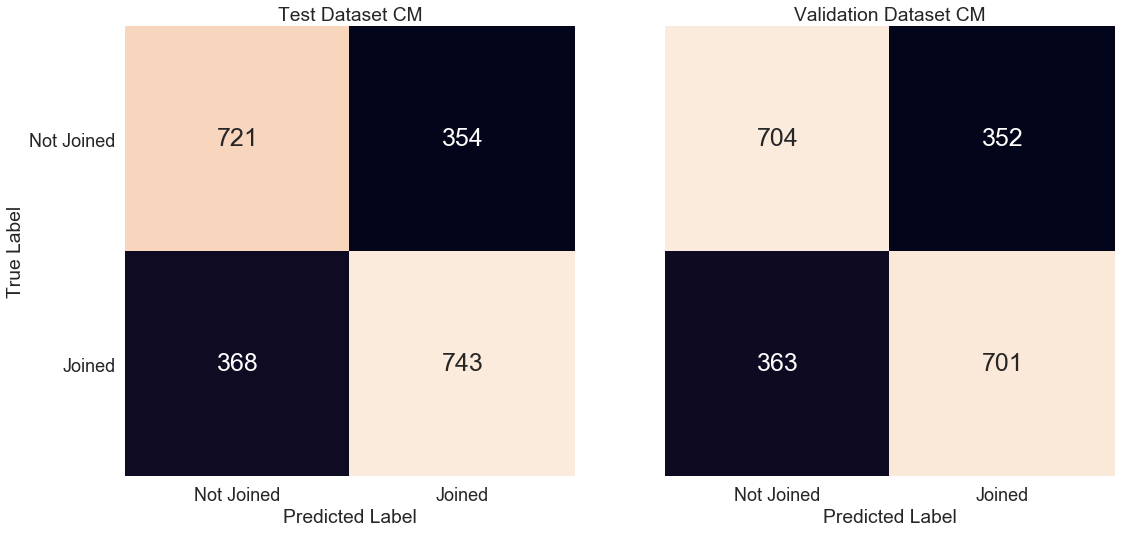

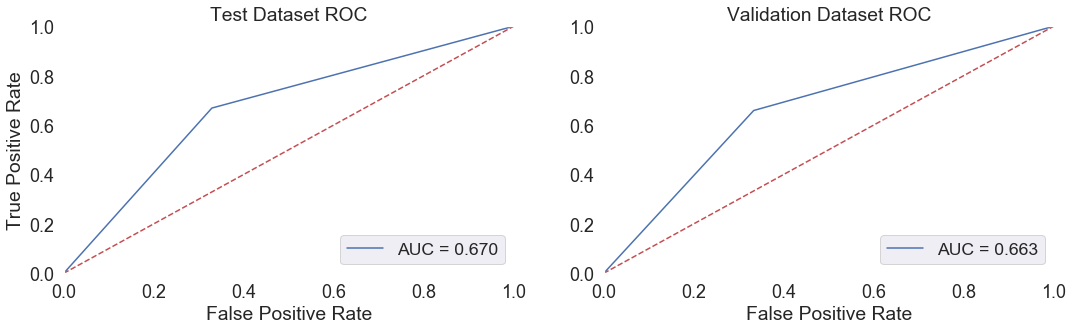

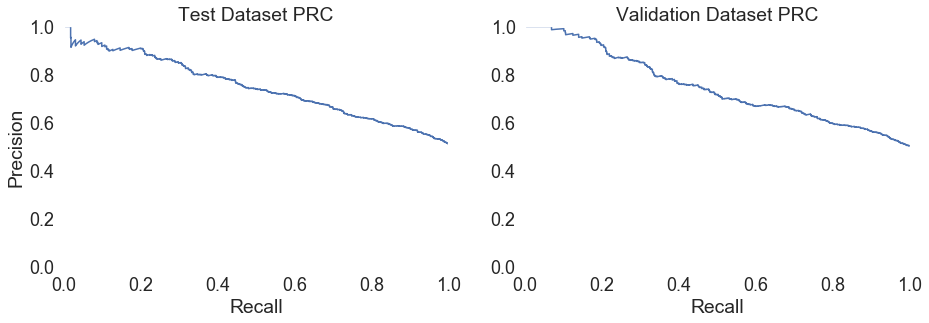

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.669716,0.662736
1,Precision,0.677302,0.665717
2,Recall,0.668767,0.658835
3,F1 Score,0.673007,0.662258


In [64]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# Random Forest model.

In [65]:
# Create Random Forest model, fit the model to the training data.
model = RandomForestClassifier(labelCol='subscribed')
model = model.fit(train)

In [66]:
# Get predictions for the testing data.
test_preds = model.transform(test)

# Get predictions for the validation data.
valid_preds = model.transform(valid)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [67]:
# Lists of actual labels and predicted labels.
test_actual = test_preds.select('subscribed').collect()
test_pred = test_preds.select('prediction').collect()

# Useful statistics
test_accuracy = metrics.accuracy_score(test_actual, test_pred)
test_precision = metrics.precision_score(test_actual, test_pred)
test_recall = metrics.recall_score(test_actual, test_pred)
test_f1_score = metrics.f1_score(test_actual, test_pred)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [68]:
# Lists of actual labels and predicted labels.
valid_actual = valid_preds.select('subscribed').collect()
valid_pred = valid_preds.select('prediction').collect()

# Useful statistics
valid_accuracy = metrics.accuracy_score(valid_actual, valid_pred)
valid_precision = metrics.precision_score(valid_actual, valid_pred)
valid_recall = metrics.recall_score(valid_actual, valid_pred)
valid_f1_score = metrics.f1_score(valid_actual, valid_pred)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [69]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [70]:
test_cm = metrics.confusion_matrix(test_actual, test_pred)
valid_cm = metrics.confusion_matrix(valid_actual, valid_pred)

### Receiver Operating Characteristics.

In [71]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(test_actual, test_pred)
test_auc = metrics.auc(test_fpr, test_tpr)

In [72]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(valid_actual, valid_pred)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [73]:
# Get subscribed probability on test predictions.
test_probs_rows = test_preds.select('probability').collect()
test_probs = [test_probs_rows[i][0][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(test_actual, test_probs)

In [74]:
# Get subscribed probability on validation predictions.
valid_probs_rows = valid_preds.select('probability').collect()
valid_probs = [valid_probs_rows[i][0][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(valid_actual, valid_probs)

## Plot graphs and statistics.

In [75]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [76]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

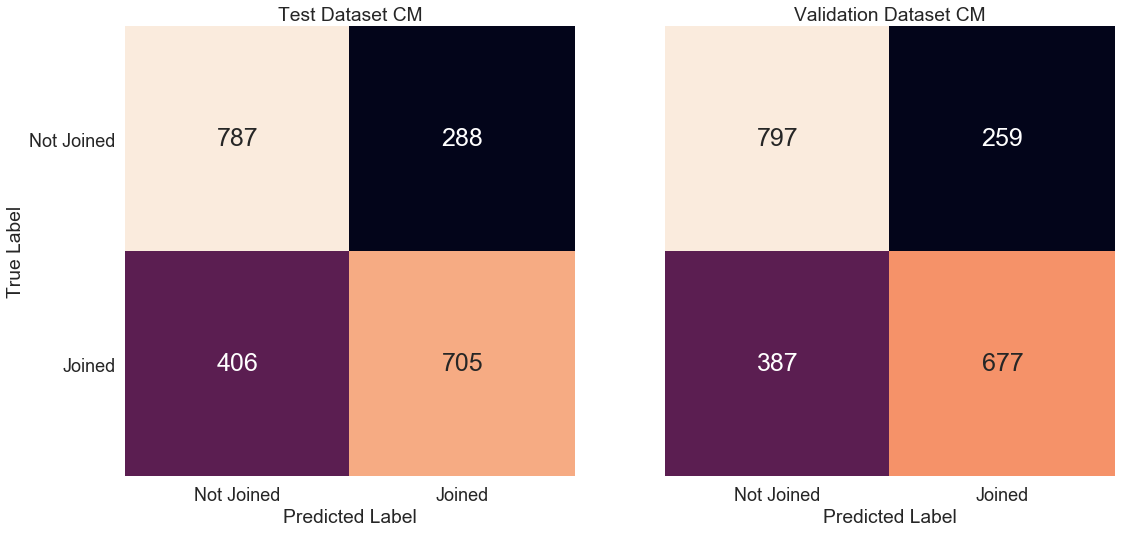

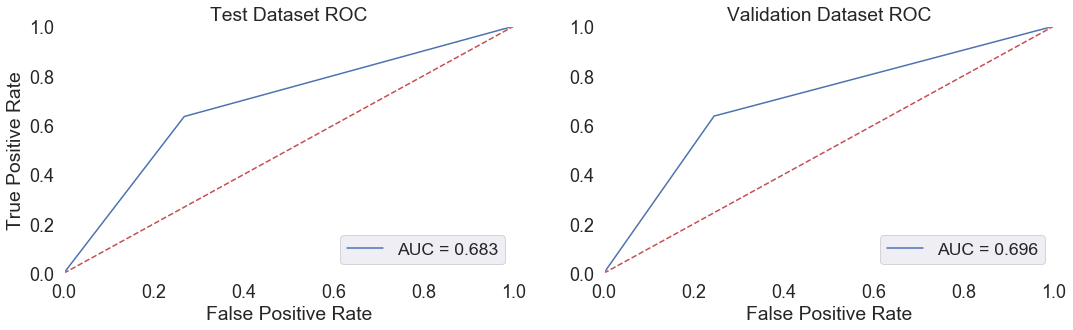

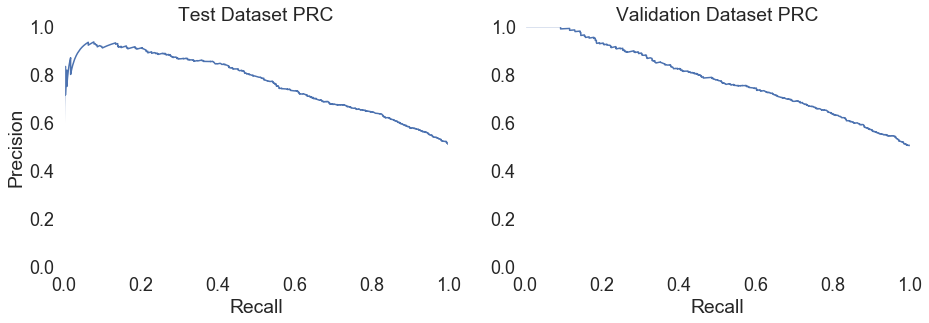

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.682525,0.695283
1,Precision,0.70997,0.723291
2,Recall,0.634563,0.636278
3,F1 Score,0.670152,0.677


In [77]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

In [78]:
duration = 1000  # milliseconds
freq = 1000  # Hz

In [79]:
sound.Beep(freq, duration)